In [20]:
# --- Sistema e utilidades ---
import os
import glob
import warnings
warnings.filterwarnings("ignore")

# --- Manipulação de dados ---
import numpy as np
import pandas as pd

# --- Visualização básica ---
import matplotlib.pyplot as plt

# --- Processamento de sinais ---
from scipy.signal import (
    butter,
    filtfilt,
    hilbert,
    welch,
    detrend
)
from scipy.signal import detrend, welch
from scipy.stats import kurtosis, skew

# --- Estatísticas ---
from scipy.stats import (
    kurtosis,
    skew
)

# --- Machine Learning ---
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import (
    StandardScaler,
    RobustScaler
)
from sklearn.ensemble import RandomForestClassifier

# --- Métricas ---
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    roc_auc_score,
    classification_report,
    confusion_matrix,
    roc_curve
)

# --- Balanceamento ---
from imblearn.over_sampling import SMOTE

# --- XGBoost ---
from xgboost import XGBClassifier

print("✅ Bibliotecas importadas com sucesso!")


✅ Bibliotecas importadas com sucesso!


In [21]:
# Frequência de amostragem
fs = 51200



# 2. DEFINIÇÃO DOS CAMINHOS DOS DADOS

NORMAL_PATH = "data/normal"
IMBALANCE_PATH = "data/imbalance"
IMBALANCE_PESOS = ["25g", "30g", "35g"]

In [22]:
# 3. CARREGAMENTO DOS ARQUIVOS E ASSOCIAÇÃO DE RÓTULOS

# Classe 0: Normal
normal_files = sorted(
    glob.glob(os.path.join(NORMAL_PATH, "*.csv"))
)

# Classe 1: Desbalanceamento
imbalance_files = []
for peso in IMBALANCE_PESOS:
    peso_path = os.path.join(IMBALANCE_PATH, peso)
    if os.path.exists(peso_path):
        imbalance_files.extend(
            sorted(glob.glob(os.path.join(peso_path, "*.csv")))
        )


# Distribuição dos dados

print("Distribuição do dataset:")
print(f"Normal (0): {len(normal_files)} arquivos")
print(f"Desbalanceamento (1): {len(imbalance_files)} arquivos")
print(f"Total: {len(normal_files) + len(imbalance_files)}")

if len(normal_files) + len(imbalance_files) > 0:
    proporcao = len(normal_files) / (len(normal_files) + len(imbalance_files))
    print(f"Proporção Normal: {proporcao * 100:.1f}%")

Distribuição do dataset:
Normal (0): 49 arquivos
Desbalanceamento (1): 139 arquivos
Total: 188
Proporção Normal: 26.1%


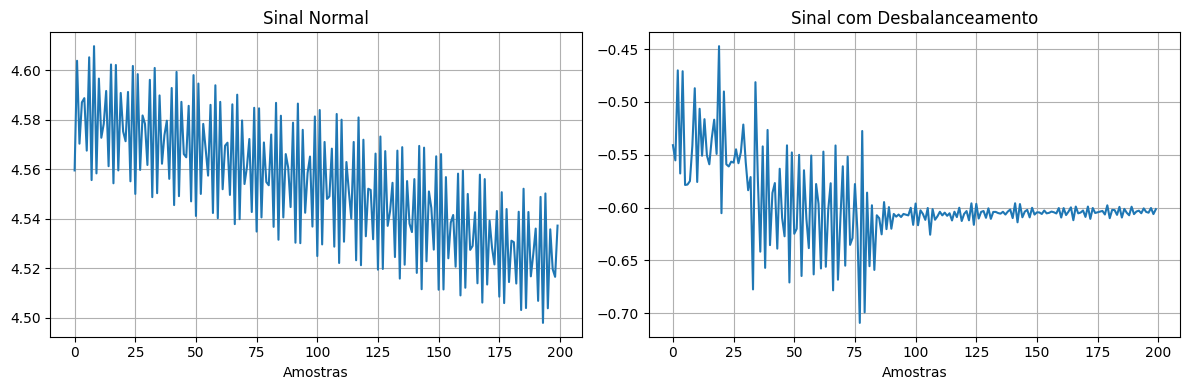

In [62]:
# VISUALIZAÇÃO DE EXEMPLOS

df_normal = pd.read_csv(normal_files[0], header=None)
df_imbalance = pd.read_csv(imbalance_files[0], header=None)

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

axes[0].plot(df_normal.iloc[:200, 0].values)
axes[0].set_title("Sinal Normal")
axes[0].set_xlabel("Amostras")
axes[0].grid(True)

axes[1].plot(df_imbalance.iloc[:200, 0].values)
axes[1].set_title("Sinal com Desbalanceamento")
axes[1].set_xlabel("Amostras")
axes[1].grid(True)

plt.tight_layout()
plt.show()

In [69]:
def dividir_janelas(sinal, tamanho=2048, overlap=0.5):
    """
    Divide o sinal em janelas com sobreposição.
    """
    passo = int(tamanho * (1 - overlap))
    janelas = []

    for i in range(0, len(sinal) - tamanho, passo):
        janelas.append(sinal[i:i + tamanho])

    return janelas


In [70]:
def extrair_features_janela(janela, fs):
    """
    Extrai features no domínio do tempo e da frequência.
    """
    f, Pxx = welch(janela, fs=fs, nperseg=1024)
    Pxx[0] = 0
    freq_dominante = f[np.argmax(Pxx)]

    return {
        "rms": np.sqrt(np.mean(janela ** 2)),
        "kurtosis": kurtosis(janela),
        "skewness": skew(janela),
        "freq_dominante": f[np.argmax(Pxx)],
        "energia_espectral": np.sum(Pxx)
    }

In [71]:
import numpy as np
from scipy.signal import detrend

def preprocessar_mafaulda(sinal, fs):
    """
    Pré-processamento básico do sinal MAFAULDA.
    - Remove tendência (DC)
    - Normaliza (z-score)
    """
    sinal = detrend(sinal)
    sinal = (sinal - np.mean(sinal)) / np.std(sinal)
    return sinal


In [72]:
# =========================================================
# CRIAÇÃO DO DATASET FINAL
# =========================================================
def criar_dataset(limite=100):
    """
    Cria o dataset MAFAULDA a partir de janelas do sinal.
    
    Rótulos:
        0 - Normal
        1 - Desbalanceamento
    """
    dados = []
    labels = []
    arquivos = []

    # Classe Normal
    for arquivo in normal_files[:limite]:
        df = pd.read_csv(arquivo, header=None)
        sinal = preprocessar_mafaulda(df.iloc[:, 0].values, fs)
        janelas = dividir_janelas(
            sinal, tamanho=2048, overlap=0.5
        )

        for janela in janelas:
            dados.append(
                extrair_features_janela(janela, fs)
            )
            labels.append(0)
            arquivos.append(arquivo)

    # Classe Desbalanceamento
    for arquivo in imbalance_files[:limite]:
        df = pd.read_csv(arquivo, header=None)
        sinal = preprocessar_mafaulda(df.iloc[:, 0].values, fs)
        janelas = dividir_janelas(
            sinal, tamanho=2048, overlap=0.5
        )

        for janela in janelas:
            dados.append(
                extrair_features_janela(janela, fs)
            )
            labels.append(1)
            arquivos.append(arquivo)

    df_final = pd.DataFrame(dados)
    df_final["label"] = labels
    df_final["arquivo_id"] = arquivos

    print("Dataset criado")
    print(f"Shape: {df_final.shape}")
    print(df_final["label"].value_counts())

    return df_final



In [73]:
# Exemplo de Execução
df = criar_dataset(limite=80)

Dataset criado
Shape: (31347, 7)
label
1    19440
0    11907
Name: count, dtype: int64


In [74]:
df.head()


,rms,kurtosis,skewness,freq_dominante,energia_espectral,label,arquivo_id
0,1.225898,1.069547,1.746167,50.0,0.010290,0,data/normal/12.288.csv
1,0.368159,1.648419,0.011243,50.0,0.000103,0,data/normal/12.288.csv
2,0.619792,25.074861,5.163780,50.0,0.000234,0,data/normal/12.288.csv
3,1.361279,-0.067733,1.383575,50.0,0.030214,0,data/normal/12.288.csv
4,1.264704,0.711631,1.640817,50.0,0.012411,0,data/normal/12.288.csv


In [75]:
df.isnull().sum()


rms                  0
kurtosis             0
skewness             0
freq_dominante       0
energia_espectral    0
label                0
arquivo_id           0
dtype: int64

In [76]:
df.groupby("label")["arquivo_id"].nunique()


label
0    49
1    80
Name: arquivo_id, dtype: int64

### 2. Pré-processamento dos dados:

In [77]:
def carregar_sinal_csv(caminho):
    df = pd.read_csv(caminho, header=None)

    sinal = pd.to_numeric(
        df.iloc[:, 0],
        errors="coerce"
    ).dropna().values

    return sinal


In [79]:
def preparar_sinal(sinal):
    return sinal.flatten()


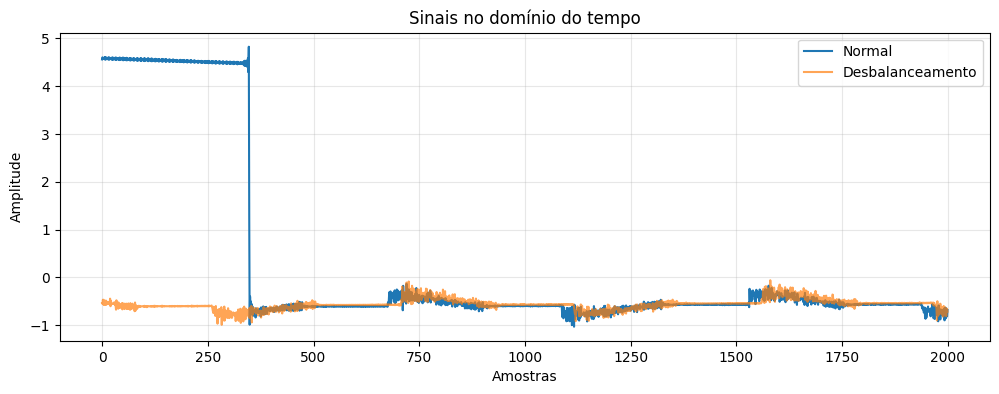

In [80]:
# Carregar sinais de exemplo
sinal_normal = carregar_sinal_csv(normal_files[0])
sinal_imb = carregar_sinal_csv(imbalance_files[0])

plt.figure(figsize=(12,4))

plt.plot(sinal_normal[:2000], label="Normal")
plt.plot(sinal_imb[:2000], label="Desbalanceamento", alpha=0.7)

plt.xlabel("Amostras")
plt.ylabel("Amplitude")
plt.title("Sinais no domínio do tempo")
plt.legend()
plt.grid(alpha=0.3)

plt.show()


In [81]:
def dividir_janelas(sinal, tamanho=2048, overlap=0.5):
    passo = int(tamanho * (1 - overlap))
    janelas = []

    for i in range(0, len(sinal) - tamanho, passo):
        janelas.append(sinal[i:i+tamanho])

    return np.array(janelas)


In [83]:
def calcular_fft(janela, fs):
    fft_vals = np.fft.rfft(janela)
    fft_mag = np.abs(fft_vals)
    freqs = np.fft.rfftfreq(len(janela), d=1/fs)

    return freqs, fft_mag


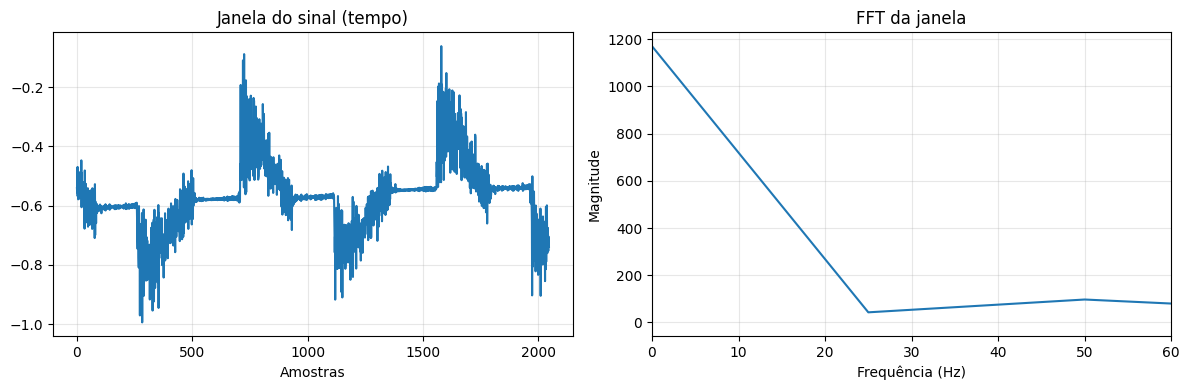

In [84]:
fs = fs  # frequência de amostragem
janela = dividir_janelas(sinal_imb, tamanho=2048, overlap=0.5)[0]

freqs, fft_mag = calcular_fft(janela, fs)

plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
plt.plot(janela)
plt.title("Janela do sinal (tempo)")
plt.xlabel("Amostras")
plt.grid(alpha=0.3)

plt.subplot(1,2,2)
plt.plot(freqs, fft_mag)
plt.title("FFT da janela")
plt.xlabel("Frequência (Hz)")
plt.ylabel("Magnitude")
plt.xlim(0, 60)
plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()


In [85]:
def extrair_features_fft(freqs, fft_mag):
    return {
        "fft_mean": np.mean(fft_mag),
        "fft_std": np.std(fft_mag),
        "fft_max": np.max(fft_mag),
        "fft_min": np.min(fft_mag),
        "freq_pico": freqs[np.argmax(fft_mag)]
    }


In [87]:
from scipy.stats import kurtosis, skew

def extrair_features_janela(janela, fs):
    freqs, fft_mag = calcular_fft(janela, fs)

    feats = {
        "rms": np.sqrt(np.mean(janela**2)),
        "kurtosis": kurtosis(janela),
        "skewness": skew(janela),
    }

    feats.update(
        extrair_features_fft(freqs, fft_mag)
    )

    return feats


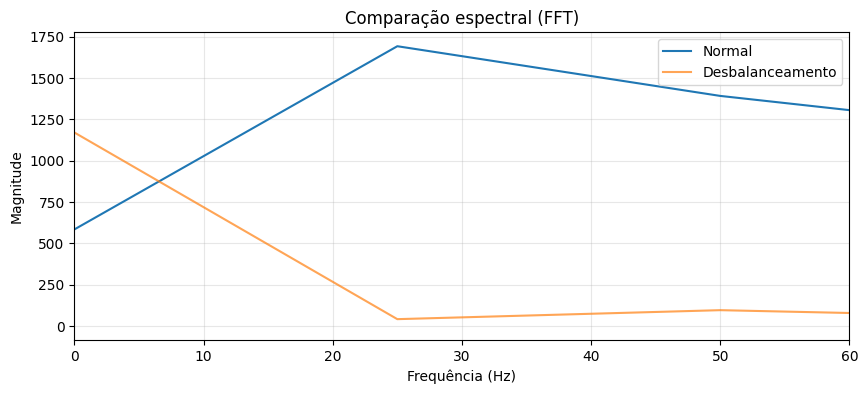

In [88]:
# FFT de uma janela normal
janela_n = dividir_janelas(sinal_normal, 2048, 0.5)[0]
freq_n, fft_n = calcular_fft(janela_n, fs)

# FFT de uma janela com desbalanceamento
janela_i = dividir_janelas(sinal_imb, 2048, 0.5)[0]
freq_i, fft_i = calcular_fft(janela_i, fs)

plt.figure(figsize=(10,4))

plt.plot(freq_n, fft_n, label="Normal")
plt.plot(freq_i, fft_i, label="Desbalanceamento", alpha=0.7)

plt.xlim(0, 60)
plt.xlabel("Frequência (Hz)")
plt.ylabel("Magnitude")
plt.title("Comparação espectral (FFT)")
plt.legend()
plt.grid(alpha=0.3)

plt.show()


In [89]:
def gerar_dataset_fft(lista_arquivos, label, fs,
                      tamanho_janela=2048,
                      overlap=0.5):

    dados = []
    labels = []
    arquivos = []

    for arquivo in lista_arquivos:
        sinal = carregar_sinal_csv(arquivo)
        sinal = preparar_sinal(sinal)

        janelas = dividir_janelas(
            sinal,
            tamanho=tamanho_janela,
            overlap=overlap
        )

        for janela in janelas:
            feats = extrair_features_janela(janela, fs)

            dados.append(feats)
            labels.append(label)
            arquivos.append(arquivo)

    X = pd.DataFrame(dados)
    y = np.array(labels)

    return X, y, arquivos


In [90]:
X_normal, y_normal, arq_normal = gerar_dataset_fft(
    normal_files,
    label=0,
    fs=fs
)

X_imb, y_imb, arq_imb = gerar_dataset_fft(
    imbalance_files[:80],
    label=1,
    fs=fs
)

X = pd.concat([X_normal, X_imb], ignore_index=True)
y = np.concatenate([y_normal, y_imb])


In [91]:
X.isna().sum()


rms          0
kurtosis     0
skewness     0
fft_mean     0
fft_std      0
fft_max      0
fft_min      0
freq_pico    0
dtype: int64

### 3. Balanceamento e divisão dos dados:

In [92]:
from sklearn.utils import resample

# Criar DataFrame unificado
df = X.copy()
df["label"] = y
df["arquivo_id"] = arquivo_id

# Separar por classe
df_0 = df[df.label == 0]
df_1 = df[df.label == 1]

# Tamanho da classe minoritária
n_min = min(len(df_0), len(df_1))

# Subamostragem da classe majoritária
df_0_bal = resample(
    df_0,
    replace=False,
    n_samples=n_min,
    random_state=42
)

df_1_bal = resample(
    df_1,
    replace=False,
    n_samples=n_min,
    random_state=42
)

# Dataset balanceado
df_bal = pd.concat([df_0_bal, df_1_bal]).sample(
    frac=1, random_state=42
).reset_index(drop=True)

print(df_bal["label"].value_counts())


label
1    11907
0    11907
Name: count, dtype: int64


In [93]:
from sklearn.model_selection import GroupShuffleSplit

X_bal = df_bal.drop(columns=["label", "arquivo_id"])
y_bal = df_bal["label"].values
groups = df_bal["arquivo_id"].values

gss = GroupShuffleSplit(
    n_splits=1,
    train_size=0.7,
    random_state=42
)

train_idx, val_idx = next(
    gss.split(X_bal, y_bal, groups)
)

X_train = X_bal.iloc[train_idx]
X_val = X_bal.iloc[val_idx]

y_train = y_bal[train_idx]
y_val = y_bal[val_idx]


In [94]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)


In [95]:
print("Treino:", X_train_scaled.shape)
print("Validação:", X_val_scaled.shape)

print("Distribuição treino:", np.bincount(y_train))
print("Distribuição validação:", np.bincount(y_val))


Treino: (16689, 8)
Validação: (7125, 8)
Distribuição treino: [8505 8184]
Distribuição validação: [3402 3723]


### 4. Construção do modelo:

In [136]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

# Modelo Random Forest
RandomForestClassifier(
    n_estimators=500,
    max_depth=10,
    min_samples_leaf=10,
    max_features='sqrt',
    class_weight='balanced',
    random_state=42,
    n_jobs=-1
)

# Treinamento
rf_clf.fit(X_train_scaled, y_train)

# Predição
y_pred_rf = rf_clf.predict(X_val_scaled)

# Avaliação
print("Random Forest")
print("Acurácia:", accuracy_score(y_val, y_pred_rf))
print(classification_report(y_val, y_pred_rf))


Random Forest
Acurácia: 0.6064561403508771
              precision    recall  f1-score   support

           0       0.61      0.48      0.54      3402
           1       0.60      0.72      0.66      3723

    accuracy                           0.61      7125
   macro avg       0.61      0.60      0.60      7125
weighted avg       0.61      0.61      0.60      7125



In [137]:
from xgboost import XGBClassifier

xgb_clf = XGBClassifier(
    n_estimators=300,
    max_depth=6,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    eval_metric='logloss'
)

xgb.fit(X_train, y_train)

y_pred_xgb = xgb.predict(X_val)

print("XGBoost")
print("Acurácia:", accuracy_score(y_val, y_pred_xgb))
print(classification_report(y_val, y_pred_xgb))


XGBoost
Acurácia: 0.6037894736842105
              precision    recall  f1-score   support

           0       0.61      0.47      0.53      3402
           1       0.60      0.73      0.66      3723

    accuracy                           0.60      7125
   macro avg       0.61      0.60      0.59      7125
weighted avg       0.61      0.60      0.60      7125



### 6. Avaliação do modelo:

In [141]:
from sklearn.metrics import classification_report, roc_auc_score

print("Random Forest")
print(classification_report(
    y_val, 
    y_pred_rf, 
    target_names=["Normal", "Falha"]
))

auc_rf = roc_auc_score(y_val, y_proba_rf)
print(f"AUC Random Forest: {auc_rf:.3f}")

print("\nXGBoost")
print(classification_report(
    y_val, 
    y_pred_xgb, 
    target_names=["Normal", "Falha"]
))

auc_xgb = roc_auc_score(y_val, y_proba_xgb)
print(f"AUC XGBoost: {auc_xgb:.3f}")


Random Forest
              precision    recall  f1-score   support

      Normal       0.61      0.48      0.54      3402
       Falha       0.60      0.72      0.66      3723

    accuracy                           0.61      7125
   macro avg       0.61      0.60      0.60      7125
weighted avg       0.61      0.61      0.60      7125

AUC Random Forest: 0.636

XGBoost
              precision    recall  f1-score   support

      Normal       0.61      0.47      0.53      3402
       Falha       0.60      0.73      0.66      3723

    accuracy                           0.60      7125
   macro avg       0.61      0.60      0.59      7125
weighted avg       0.61      0.60      0.60      7125

AUC XGBoost: 0.621


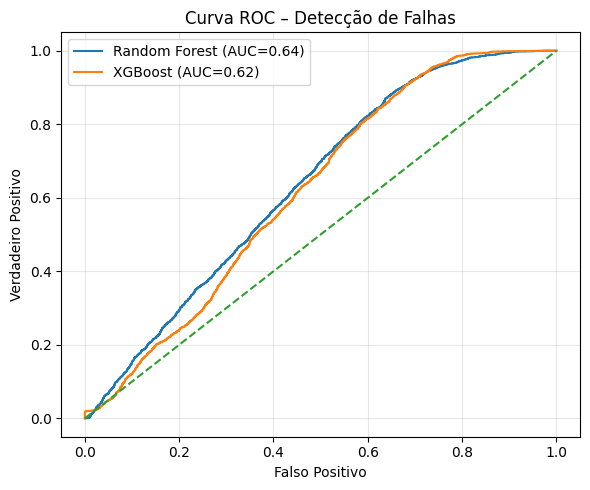

In [142]:
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt

fpr_rf, tpr_rf, _ = roc_curve(y_val, y_proba_rf)
fpr_xgb, tpr_xgb, _ = roc_curve(y_val, y_proba_xgb)

plt.figure(figsize=(6,5))
plt.plot(fpr_rf, tpr_rf, label=f"Random Forest (AUC={auc_rf:.2f})")
plt.plot(fpr_xgb, tpr_xgb, label=f"XGBoost (AUC={auc_xgb:.2f})")
plt.plot([0,1], [0,1], linestyle="--")

plt.xlabel("Falso Positivo")
plt.ylabel("Verdadeiro Positivo")
plt.title("Curva ROC – Detecção de Falhas")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


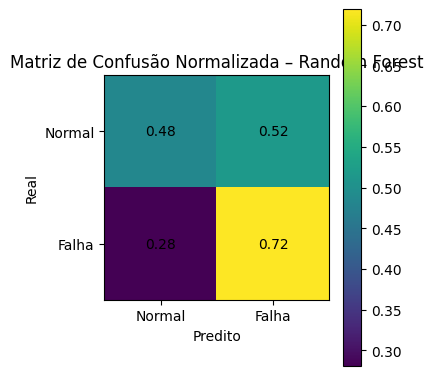

In [144]:
cm = confusion_matrix(y_val, y_pred_rf, normalize="true")

plt.figure(figsize=(4,4))
plt.imshow(cm)
plt.colorbar()
plt.xticks([0,1], ["Normal", "Falha"])
plt.yticks([0,1], ["Normal", "Falha"])
plt.xlabel("Predito")
plt.ylabel("Real")
plt.title("Matriz de Confusão Normalizada – Random Forest")

for i in range(2):
    for j in range(2):
        plt.text(j, i, f"{cm[i,j]:.2f}", ha="center", va="center")

plt.tight_layout()
plt.show()


### 7. Visualização dos resultados: